### Reference:

1. https://www.opcito.com/blogs/extracting-text-from-images-with-tesseract-ocr-opencv-and-python
2. https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i
3. https://www.youtube.com/watch?v=UxYJxcdLrs0&list=PL2VXyKi-KpYuTAZz__9KVl1jQz74bDG7i&index=3

In [1]:
# install pesseract for windowa as explained at the following link
# https://stackoverflow.com/questions/50951955/pytesseract-tesseractnotfound-error-tesseract-is-not-installed-or-its-not-i

### importing modules

In [17]:
# importing modules
import cv2
from PIL import Image

import pytesseract
from pytesseract import Output

from matplotlib import pyplot as plt
import numpy as np

from pdf2image import convert_from_path

### Import image in PDF and save the image

In [3]:
pages = convert_from_path('scan-to-pdf-04.pdf')

print(len(pages))

for count, page in enumerate(pages):
    page.save(f'SP149292_out{count}.jpg', 'JPEG')

1


### Load image using PIL

In [4]:
img_file = 'SP149292_out0.jpg'

11606118


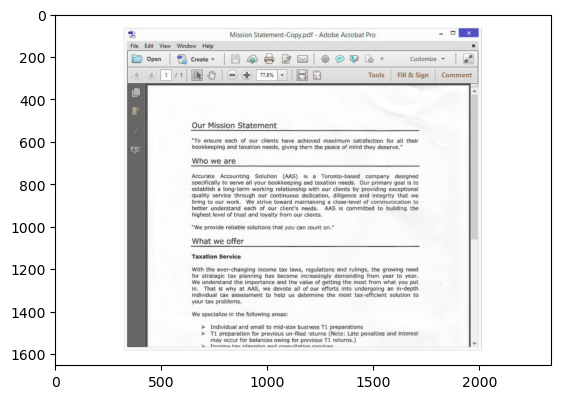

In [6]:
img = cv2.imread(img_file)
print(img.size)
plt.imshow(img)

## Do some preprocessing

### 1. Iverted Image

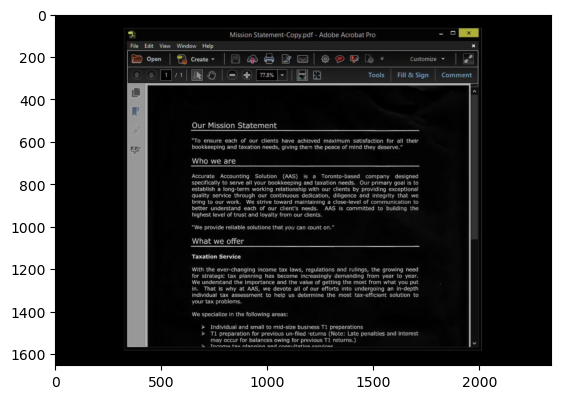

In [11]:
inverted_img = cv2.bitwise_not(img)
plt.imshow(inverted_img)

### 2. Rescaling

### 3. Binarization (gray then binary)

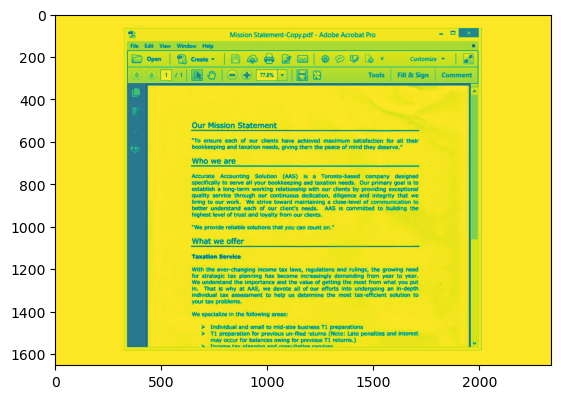

In [14]:
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)

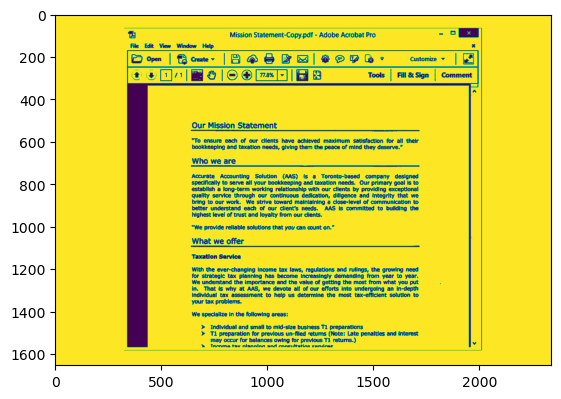

In [16]:
thresh, im_bw = cv2.threshold(gray_image, 200, 230, cv2.THRESH_BINARY)
plt.imshow(im_bw)

### 4. Noise Removal through Dilation and Erosion

In [22]:
def noise_removal(img):
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(img, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 3)
    return image

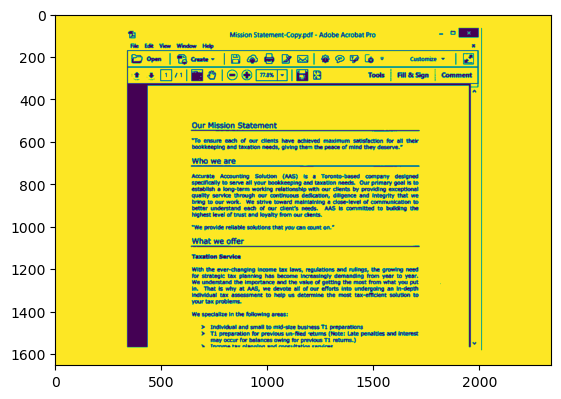

In [24]:
no_noise = noise_removal(im_bw)
plt.imshow(no_noise)

### 5. Fix thickness through Dilation and Erosion

In [27]:
def thin_font(img):
    image = cv2.bitwise_not(img)
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return image

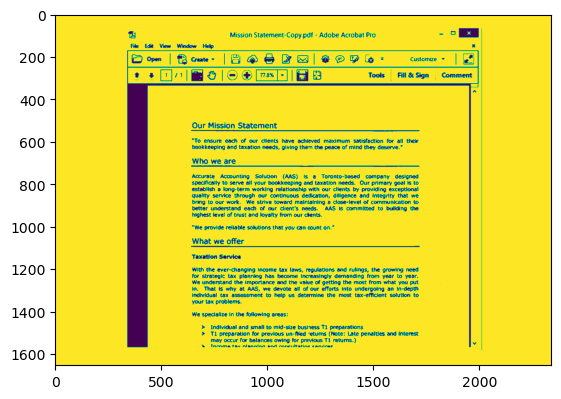

In [28]:
eroded_image = thin_font(no_noise)
plt.imshow(eroded_image)

In [29]:
def thick_font(img):
    image = cv2.bitwise_not(img)
    kernel = np.ones((2,2), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    image = cv2.bitwise_not(image)
    return image

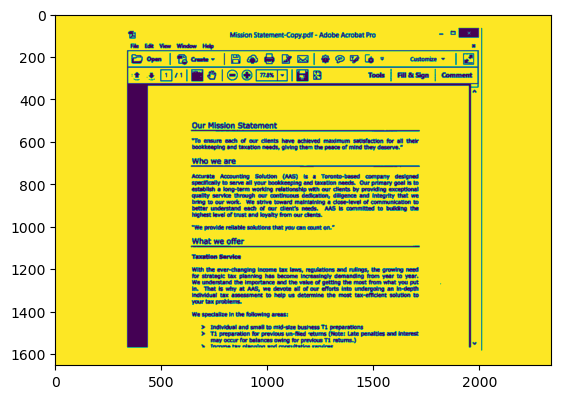

In [32]:
dilated_image = thick_font(no_noise)
plt.imshow(dilated_image)

### 6. Rotation and Deskewing

In [33]:
# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

In [34]:
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

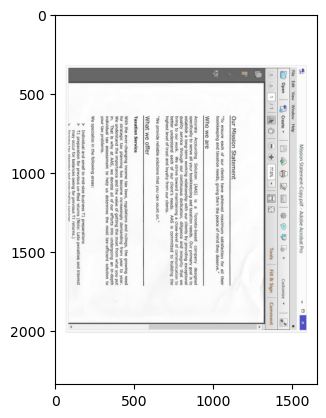

In [50]:
rotated = cv2.imread(r'temp\rotated.jpg')
plt.imshow(rotated)

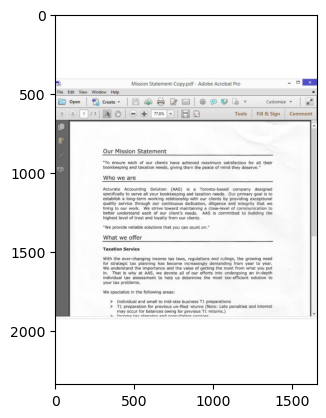

In [51]:
fixed = deskew(rotated)
plt.imshow(fixed)

### 7. Removing Borders

In [64]:
def remove_borders(img):
    contours, heiarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = img[y:y+h, x:x+w]
    return (crop)

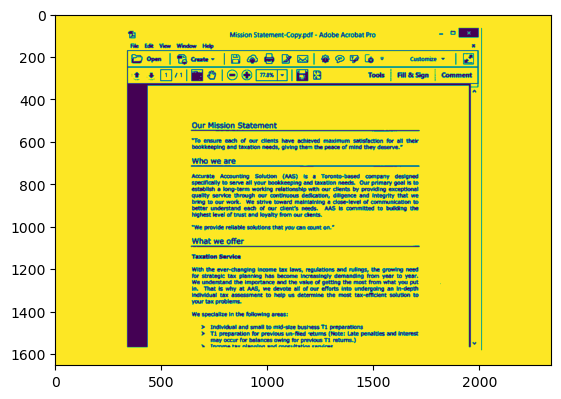

In [68]:
no_borders = remove_borders(no_noise) # p.n. bounding box might be better to remove
plt.imshow(no_borders)

### 8. Adding borders

In [69]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

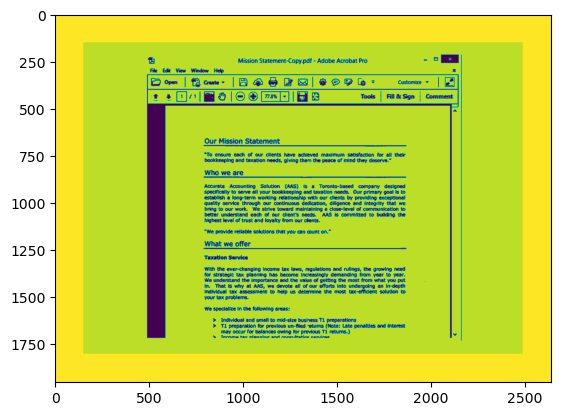

In [70]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value = color)
plt.imshow(image_with_border)

In [ ]:
im.save(r'temp\temp_SP149292_out0.jpg')